In [32]:
import numpy as np
import matplotlib
import scipy.integrate
matplotlib.rcParams['savefig.dpi'] = 300
import matplotlib.pyplot as plt
import sys

In [33]:
def right_hand_side(u, rho, C_D, r, m):
    v_vec = u[2:]
    norm_v = np.linalg.norm(v_vec)
    v_normalized = v_vec / norm_v
    
    A = np.pi * r**2
    
    drag = 0.5 * rho * C_D * norm_v **2 * A
    
    return np.array([v_vec[0], 
                     v_vec[1],
                     0*-drag/m * v_normalized[0], 
                     0*-drag/m * v_normalized[1] - g, 
                    ])

def simulate_until_impact(h_0, x_0, v_0, alpha, g, C_D, rho, dt):
    # We need to solve an ODE
    u_0 = np.array([x_0, h_0, v_0*np.cos(alpha), v_0*np.sin(alpha)])
    
    # WARNING: This is not the most effective way of doing this
    # but it is used for educational purposes.
    t = [0]
    u = [u_0]
    
    
    while u[-1][1] > 0:
        u.append(u[-1] + dt * right_hand_side(u[-1], rho, C_D, r, m))
        
        t.append(t[-1] + dt)

    return np.array(u), np.array(t)

@np.vectorize
def p(h_0, x_0, v_0, alpha, g, C_D, rho, dt):
    u, t = simulate_until_impact(h_0, x_0, v_0, alpha, g, C_D, rho, dt)
    
    return u[-1][0]
        


In [27]:
x_0 = 0.2
v_0 =20
alpha = np.pi/12
h_0 = 0.5

N = 500

g = 9.81

C_D = 0.1

m = 0.142

r = 0.22

rho = 1.1455


In [30]:
def compute_monte_carlo_ensemble(M, dt):
    x_0 = 0.2
    v_0 = np.random.uniform(15,25, M)
    alpha = np.random.uniform(0, 5*np.pi/12, M)
    h_0 = np.random.uniform(0,1, M)
    
    C_D = np.random.uniform(0.07, 0.13, M)
    m = np.random.uniform(0.12, 0.16, M)
    
    r = np.random.uniform(0.2, 0.24, M)
    
    rho = np.random.uniform(1.1, 1.4, M)
    
    
    ensemble = p(h_0, x_0, v_0, alpha, g, C_D, rho, dt)
    
    return ensemble

def compute_monte_carlo(M, dt):
    ensemble = compute_monte_carlo_ensemble(M, dt)
    return np.mean(ensemble), np.var(ensemble)

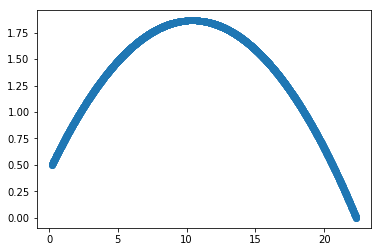

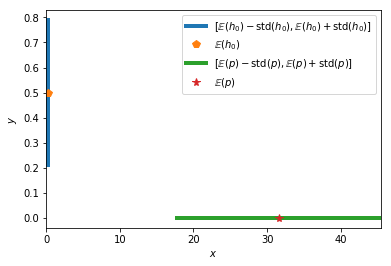

In [29]:
u, t = simulate_until_impact(h_0, x_0, v_0, alpha, g, C_D, rho, 1/2048.)

plt.plot(u[:, 0], u[:, 1], 'o')
plt.show()
# Plot the different height possibilities
plt.plot([x_0, x_0], [0.5-np.sqrt(1.0/12.0), 0.5+np.sqrt(1.0/12.0)],
    linewidth=4, label='$[\\mathbb{E}(h_0)-\\mathrm{std}(h_0), \\mathbb{E}(h_0)+\\mathrm{std}(h_0)]$')

plt.plot(x_0, 0.5, 'p', markersize=8, label='$\\mathbb{E}(h_0)$')

M=1024
mean, var = compute_monte_carlo(M, 1.0/np.sqrt(M))

std = np.sqrt(var)

plt.plot([mean - std, mean+std], [0, 0], linewidth=4,
    label='$[\\mathbb{E}(p)-\\mathrm{std}(p), \\mathbb{E}(p)+\\mathrm{std}(p)]$')
plt.plot([mean], [0], '*', markersize=8, label='$\\mathbb{E}(p)$')
plt.legend()
plt.xlim([0, mean+std])

plt.xlabel('$x$')
plt.ylabel('$y$')

plt.savefig('uncertain_height_angle.png')

plt.show()


# Convergence plots

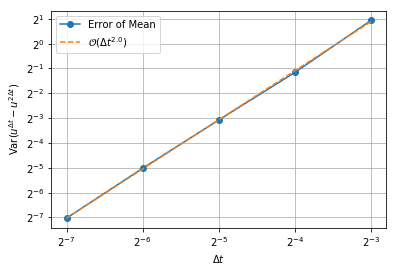

In [38]:


dts = 2.0**(-np.arange(3, 8))

variance_decay = []

M = 2048
for dt in dts:
    sys.stdout.write('{}\r'.format(np.log2(dt)))
    sys.stdout.flush()
    np.random.seed(0)
    ensemble_l   = compute_monte_carlo_ensemble(2048, dt)
    np.random.seed(0)
    ensemble_lm1 = compute_monte_carlo_ensemble(2048, 2*dt)
    
    variance_decay.append(np.var(ensemble_l - ensemble_lm1))
    

variance_decay = np.array(variance_decay, dtype=np.float64)

plt.loglog(dts, variance_decay, '-o', label='$\\mathrm{Var}(u^{\\Delta t}-u^{2\\Delta t})$')
fitted = np.polyfit(np.log(dts), np.log(variance_decay), 1)
plt.loglog(dts, np.exp(fitted[1])*dts**(fitted[0]), '--',
    label='$\\mathcal{{O}}(\\Delta t^{{{:.1f}}})$'.format(fitted[0]),
          basex=2, basey=2)
plt.xlabel('$\\Delta t$')
plt.ylabel("$\\mathrm{Var}(u^{\\Delta t}-u^{2\\Delta t})$")
plt.grid(True)
plt.legend()
plt.savefig('uncertain_height_angle_convergence.png')
plt.show()
